## 1. Import Libraries

In [1]:


import math
import torchtext
import torch
import torch.nn as nn
from torch import Tensor
from collections import Counter
from torchtext.vocab import Vocab
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import io
import time
import pickle
import numpy as np
import pandas as pd
import sentencepiece as spm

from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
print('device: ',device)

device:  cuda


# 2. Drive Mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Analysis the Dataset

In [5]:
dataset_path='/content/drive/MyDrive/research and innovation/nlp2.csv'
df=pd.read_csv(dataset_path)
df.head()

,Chittagonian,Bengali
0,আঁর,আমার
1,বাড়ি,বারি
2,আঁরার,আমাদের
3,আঁরো বারিত কনো কিয়া নো আইয়ি,আমাদের বাড়িতে কেউ আসে নাই
4,আলমিরা,আলমারি


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Chittagonian  1103 non-null   object
 1   Bengali       1103 non-null   object
dtypes: object(2)
memory usage: 17.4+ KB


### Check unique values in dataframe

In [7]:
def report_data_types_uniques_check(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []

    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())

    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

In [8]:
report_data_types_uniques_check(df)

,Column,d_type,unique_sample,n_uniques
0,Chittagonian,object,"[আঁর, বাড়ি, আঁরার, আঁরো বারিত কনো কিয়া নো আই...",941
1,Bengali,object,"[আমার, বারি, আমাদের, আমাদের বাড়িতে কেউ আসে না...",939


In [9]:
# check missing values
df.isnull().sum()

Chittagonian    0
Bengali         0
dtype: int64

### Select top 1000 data for the project

In [10]:
top_1000_df=df.head(1000)
top_1000_df.head()

,Chittagonian,Bengali
0,আঁর,আমার
1,বাড়ি,বারি
2,আঁরার,আমাদের
3,আঁরো বারিত কনো কিয়া নো আইয়ি,আমাদের বাড়িতে কেউ আসে নাই
4,আলমিরা,আলমারি


In [11]:
top_1000_df.describe()

,Chittagonian,Bengali
count,1000,1000
unique,875,858
top,আযল্‌,হঠাৎ
freq,7,8


### Select only the chattogram sentence and bangali sentence

In [13]:
original_chattogram_Sentense=list(top_1000_df['Chittagonian'])
bangali_sentence=list(top_1000_df['Bengali'])

## 4. Data Processing
- Generate train and val data
- Save chattogram and stanadrd bangla text into local disk

In [14]:
data=[]
# print(Original_Chattogram_Sentense)
for i in range(len(original_chattogram_Sentense)):
  data.append([original_chattogram_Sentense[i],bangali_sentence[i]])


In [15]:
data[:100]

[['আঁর', 'আমার'],
 ['বাড়ি', 'বারি'],
 ['আঁরার', 'আমাদের'],
 ['আঁরো বারিত কনো কিয়া নো আইয়ি', 'আমাদের বাড়িতে কেউ আসে নাই'],
 ['আলমিরা', 'আলমারি'],
 ['আইয়্যির', 'আসছে'],
 ['লা~রে লা~রে', 'আস্তে আস্তে'],
 ['নোয়া', 'নতুন'],
 ['ন', 'নয়'],
 ['ফন্না', 'পড়ালেখা'],
 ['বন্নাই', 'নিন্দা'],
 ['লাশারা', 'নির্লজ্জ'],
 ['ফা৴না', 'পাঁকা'],
 ['ফইর', 'পুকুর'],
 ['আঁই গঅঁম আছি', 'আমি ভাল আছি'],
 ['আত্তে গঅঁম ন লাগের', 'আমার ভাল লাগছে না'],
 ['তুঁই হন্ডে যঁর', 'তুমি কোথায় যাচ্ছ'],
 ['হন্ডে', 'কোথায়'],
 ['তুঁই হন্ডে থাহ', 'তুমি কোথায় থাক'],
 ['আঁর দিলুত শান্তি নাই', 'আমার মন ভালো নেই'],
 ['আই কিচ্চি', 'আমি কি করলাম'],
 ['হালত', 'পরিস্থিতি'],
 ['হঅন', 'খাওয়া'],
 ['চিটাইঙ্গা', 'চট্টগ্রামবাসী'],
 ['সমস্ত মানুষ', 'বিয়াক মানুশ'],
 ['ইজ্\u200cজত', 'মর্যাদা '],
 ['বিয়াক মানুশ ইজ্\u200cজত এদ\u200c্দে অ়কর ই়শাবে আজাদ আর উ়য়াইন্\u200cনা অ়ইয়েরে ফ়য়দা অ়য়। ই়তারাত্\u200cতু আহল এদ্\u200cদে বিবেক আছে ; এতল্\u200cলায় এজ্\u200cজন আরেজ্\u200cজনর উ়য়ারে ভাইয়ুর নান বেভার গরন দরহার।',
  'সমস্ত মানুষ স্বাধীনভাবে জ

In [16]:
data[-100:]

[['আবেদ্\u200c', 'নিষ্ঠাবান'],
 ['আবেদ্\u200c', 'সত্যবাদী'],
 ['আবেদ্\u200c', 'সরল'],
 ['আব্\u200c', 'জল'],
 ['আব্\u200c', 'পানি'],
 ['আব্\u200c', 'অভ্র'],
 ['আব্\u200cদালি করা', 'দুষ্টামি করা'],
 ['আব্\u200cবিশ্\u200c', 'মধ্যস্থনে'],
 ['আব্\u200cবিশ্\u200c', 'খেলার মধ্যরেখা'],
 ['আব্\u200cবুইশ্\u200c', 'খেলার মধ্যরেখা'],
 ['আব্\u200cবুইশ্\u200c', 'মধ্যস্থনে'],
 ['আব্\u200cযল্\u200c', 'ভাল'],
 ['আব্\u200cযল্\u200c', 'শ্রেষ্ঠ'],
 ['আব্\u200cযান্\u200c', 'বন্ধ করা'],
 ['আব্\u200cযান্\u200c', 'এক পাশ্বে সরাইয়া রাখা'],
 ['আমতত্\u200c', 'বিনা বাক্য ব্যয়ে'],
 ['আমতত্\u200c', 'বিনা ওজরে'],
 ['আমতত্\u200c', 'নিঃশব্দে'],
 ['আমবুব্\u200cন', 'হামাগুড়ি দেওয়া'],
 ['আমল্\u200c', 'খেয়াল'],
 ['আমল্\u200c', 'মনোযোগ'],
 ['আমা', 'চোখের ছানি'],
 ['আমাইন্\u200cশামি', 'অমানুষিকতা'],
 ['আমাইন্\u200cশামি', 'অমানবিকতা'],
 ['আমাত্\u200c', 'বোবা'],
 ['আমাত্\u200c', 'নির্বাক'],
 ['আমাত্\u200cতা', 'আবার'],
 ['আমান্\u200cতা', 'জমা'],
 ['আমারে মা', 'আশ্চার্যবোধক শব্দ'],
 ['আমাশা', 'আমাশয় রোগ'],
 ['আমি', 'হাই'],
 ['আ

In [17]:
train_chattogram = [i[0] for i in data[:800]]
val_chattogram = [i[0] for i in data[800:]]
print('train len: ',len(train_chattogram))
print(' val len: ',len(val_chattogram))

train len:  800
 val len:  200


In [18]:
val_chattogram[:10]

['আনা',
 'আনা হনি',
 'আনাআশ্\u200c',
 'আনাইল্\u200cলা',
 'আনাইল্\u200cলা',
 'আনাযি',
 'আনাযি কেলা',
 'আনিনিগন্\u200c',
 'আনিবাল্\u200cলায়',
 'আনুনা']

In [19]:
train_bangla = [i[1] for i in data[:800]]
val_bangla = [i[1] for i in data[800:]]
print(len(train_bangla))
print(len(val_bangla))

800
200


In [20]:
val_bangla[:10]

['আয়না',
 'আয়না ও চিরুণি',
 'আনারস',
 'বুনো',
 'আনাইল্\u200cলা কচু',
 'কাঁচা তরকারি',
 'এক প্রকার কাঁচা কলা',
 'কায়ক্লেশে দিন যাপন',
 'আনিবার জন্য',
 'লবণহীন']

### Saved Chattogram and standard bangla text into file

In [21]:
import os
process_data_path = "/content/drive/MyDrive/Chattogram_language/data/process_data"
# os.makedirs(process_data_path, exits_ok= True)
os.makedirs(process_data_path, exist_ok = True)

In [22]:
def write_txt_file(file_path, data, encoding="utf-8"):
    with open(file_path, 'w') as f:
        for key in data:
            if isinstance(key, list):
                key = key[0]
            f.write(key+"\n")

In [23]:
write_txt_file(os.path.join(process_data_path, "chattogram_data.txt"), train_chattogram)

In [24]:
write_txt_file(os.path.join(process_data_path,"bangla_data.txt"), train_bangla)

In [25]:
def merge_data_write_txt_file(file_path, chattogram_data, bangla_data, encoding="utf-8"):
    with open(file_path, 'w') as f:
        for chattogram, bangla in zip(chattogram_data, bangla_data):
#             if isinstance(key, list):
#                 key = key[0]
            f.write(chattogram+"\t"+bangla+"\n")

In [26]:
merge_data_write_txt_file(os.path.join(process_data_path, "merge_data.txt"), train_chattogram, train_bangla)

In [27]:
model_path = "/content/drive/MyDrive/Chattogram_language/model"
os.makedirs(model_path, exist_ok = True)

## 5. Generate Tokenizer and Vocab File

In [28]:
import sentencepiece as spm

def train_tokenizer(text_path="text.txt", model_prefix="model/chattogram_model", vocab_size=30000):
    spm.SentencePieceTrainer.train(f'--input={text_path} --model_prefix={model_prefix} --user_defined_symbols=<sep>,<cls> --vocab_size={vocab_size}')
    bn_sp = spm.SentencePieceProcessor()
    bn_sp.load(os.path.join(model_path, 'chattogram_model.model'))


In [29]:
chattogram_data_path = "/content/drive/MyDrive/Chattogram_language/data/process_data/chattogram_data.txt"
bangla_data_path = "/content/drive/MyDrive/Chattogram_language/data/process_data/bangla_data.txt"

### Generate Chattogram and standard bangla tokenizer

In [31]:
train_tokenizer(
    text_path = chattogram_data_path,
    model_prefix = "/content/drive/MyDrive/Chattogram_language/model/chattogram_model",
    vocab_size = 900
)

In [33]:
train_tokenizer(
    text_path = bangla_data_path,
    model_prefix = "/content/drive/MyDrive/Chattogram_language/model/bangla_model",
    vocab_size = 900
)

In [34]:
chattogram_tokenizer = spm.SentencePieceProcessor(model_file='/content/drive/MyDrive/Chattogram_language/model/chattogram_model.model')
bangla_tokenizer = spm.SentencePieceProcessor(model_file='/content/drive/MyDrive/Chattogram_language/model/bangla_model.model')

In [35]:
chattogram_tokenizer.encode("আর কাম গান গরি রাখ ")

[61, 10, 85, 43, 372, 129, 347, 31]

In [40]:
bangla_tokenizer.encode("আমার কাজটি করে রাখো")

[25, 69, 30, 47, 600]

In [42]:
print(chattogram_tokenizer.encode_as_pieces('আর কাম গান গরি রাখ '))
print(chattogram_tokenizer.encode_as_ids('আর কাম গান গরি রাখ '))

print(bangla_tokenizer.encode_as_pieces('আমার কাজটি করে রাখো '))
print(bangla_tokenizer.encode_as_ids('আমার কাজটি করে রাখো'))

['▁আর', '▁কাম', '▁গান', '▁গরি', '▁রাখ']
[93, 111, 670, 58, 454]
['▁আমার', '▁কাজ', 'টি', '▁করে', '▁রাখো']
[25, 69, 30, 47, 600]


### Generate and save vocab files

In [43]:
from torchtext.vocab import vocab
def build_vocab(sentences, tokenizer):
    counter = Counter()
    for sentence in sentences:
        # print(sentence)
        if isinstance(sentence, list):
            sentence = sentence[0]
        counter.update(tokenizer.encode(sentence, out_type=str))
    print(counter)
    return vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'], special_first=True)


In [44]:
torchtext.__version__

'0.17.1+cpu'

In [45]:
print('input sentence: ',train_chattogram[0])
chattogram_tokenizer.encode(train_chattogram[0])

input sentence:  আঁর


[98]

### Merge train and val to generate a vocab

In [46]:
full_chattogram=train_chattogram+val_chattogram
full_bangla=train_bangla+val_bangla
print(len(full_chattogram))
print(len(full_bangla))

1000
1000


In [47]:
full_chattogram_vocab = build_vocab(full_chattogram, chattogram_tokenizer)
print('len of full chattogram vocab: ',len(full_chattogram_vocab))

Counter({'▁আ': 236, '্': 89, 'ন্': 81, 'র': 64, '▁': 56, 'ি': 51, 'যা': 44, 'ল্': 42, 'র্': 41, 'ম্': 39, 'ত': 38, '▁অ': 34, '▁ন': 32, 'য': 32, '▁ক': 31, 'ু': 30, '▁না': 29, 'ত্': 28, 'শ্': 26, '▁গা': 26, 'বা': 25, 'ন': 24, '▁যা': 24, '▁লা': 23, 'ম': 23, 'রে': 22, 'ই': 22, 'ল': 21, 'ে': 21, 'না': 20, '▁দে': 20, '▁দ': 20, 'া': 20, 'রি': 20, '▁আট্': 20, 'ো': 19, 'রা': 19, 'স': 19, '’': 19, '▁আগ': 19, '-': 18, '▁মা': 18, '▁দি': 17, 'দ্': 17, '▁আদ': 17, '▁ত': 16, '▁তা': 16, 'ফ': 15, '▁দা': 15, '▁আব': 15, '▁আঁ': 15, '▁ব': 14, '▁আই': 13, '▁হ': 13, 'নি': 13, 'ক': 13, 'ের': 13, 'প্': 13, '▁প': 12, '▁অন্': 12, 'শা': 11, '▁হা': 11, '▁এ': 11, '▁বি': 11, '▁ম': 11, 'মি': 11, 'প': 11, '▁কা': 11, '▁আঁই': 10, '▁নাই': 10, 'য়': 10, '▁ডা': 10, 'তুন': 10, '▁গরি': 10, '▁স': 10, 'লি': 10, '▁আউ': 10, '▁গ': 9, '▁য': 9, '▁মানুষ': 9, '▁পা': 9, '▁বু': 9, 'য্': 9, 'কথা': 9, '▁কু': 9, '▁অত্': 9, 'য়া': 9, 'লা': 9, 'মা': 9, 'স্': 9, 'ং': 9, '▁আঁআ': 9, 'তা': 8, 'দে': 8, 'ডা': 8, ',': 8, '▁কাম': 8, '▁শ': 8, '▁’': 8,

In [48]:
full_bangla_vocab = build_vocab(full_bangla, bangla_tokenizer)
print('len of full chattogram vocab: ',len(full_bangla_vocab))

Counter({'র': 110, 'ের': 70, 'ি': 68, '▁': 65, 'ে': 63, 'া': 60, '▁আ': 59, 'ল': 54, 'ন': 47, '▁না': 41, 'য়': 40, 'ত': 38, 'ম': 37, '▁অ': 30, '্য': 30, 'কার': 29, '▁হ': 27, 'ী': 26, '▁ম': 25, '▁মা': 24, 'ো': 23, 'জ': 22, 'ক': 22, '▁ও': 22, '▁বা': 21, 'প': 21, '▁করা': 20, 'লা': 20, '▁এ': 20, '▁এক': 20, 'তে': 19, 'শ': 19, '▁গ': 19, '▁আমার': 18, 'ণ': 18, 'টি': 18, '▁বাজে': 18, '▁নি': 17, '▁ব': 17, 'ু': 17, '▁প': 16, '▁হয়': 16, 'দ': 16, '▁আমাদের': 15, 'না': 15, 'ব': 15, '▁ক': 15, 'বা': 15, 'কে': 15, '▁ঐ': 15, '▁অন': 15, '▁বিশেষ': 15, 'ৎ': 15, 'িত': 14, '▁বে': 14, 'হীন': 14, 'ই': 14, '▁কাজ': 14, '▁জ': 14, '▁প্র': 14, 'রি': 13, '▁নাই': 13, '▁করে': 13, '▁ফ': 13, '▁শ': 13, '▁বি': 13, '▁অবস্থা': 13, '▁ন': 12, '▁আমি': 12, 'াই': 12, '-': 12, '▁কথা': 12, 'টা': 12, '▁দেওয়া': 12, 'ঠা': 12, 'াস': 11, '▁বোকা': 11, 'িবার': 11, '▁খাবার': 11, 'িয়া': 10, 'ধ': 10, '▁ভ': 10, '্ব': 10, '্': 10, '▁জন্য': 10, 'শ্ব': 10, 'সি': 10, '▁সব': 10, '▁যে': 10, '▁চাল': 10, '▁অব': 10, '▁ভাল': 9, '▁কর': 9, '▁মানুষ': 9,

## 6. Generate Train and Val Data Loader

In [49]:
def data_process(chattogram, bangla):
    data = []
    for (raw_chattogram, raw_bangla) in zip(chattogram, bangla):
        chattogram_tensor_ = torch.tensor([full_chattogram_vocab[token] for token in chattogram_tokenizer.encode(raw_chattogram, out_type=str)],dtype=torch.long)
        bangla_tensor_ = torch.tensor([full_bangla_vocab[token] for token in bangla_tokenizer.encode(raw_bangla, out_type=str)],dtype=torch.long)
        data.append((chattogram_tensor_, bangla_tensor_))
    return data

In [50]:
train_data = data_process(train_chattogram, train_bangla)

In [51]:
train_data[:10]

[(tensor([4]), tensor([4])),
 (tensor([5]), tensor([5, 6])),
 (tensor([6, 7]), tensor([7])),
 (tensor([ 4,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
  tensor([ 7,  8,  9, 10, 11, 12])),
 (tensor([17, 18]), tensor([13, 14])),
 (tensor([19, 20, 21]), tensor([15])),
 (tensor([22, 23, 24, 22, 23, 24]), tensor([16, 16])),
 (tensor([25, 26]), tensor([17, 18, 19])),
 (tensor([25]), tensor([20])),
 (tensor([27, 28]), tensor([21, 22, 23]))]

In [52]:
val_data = data_process(val_chattogram, val_bangla)

In [53]:
val_data[:10]

[(tensor([19, 35]), tensor([ 37, 100,  99])),
 (tensor([ 19,  35,  64, 180]), tensor([ 37, 100,  99,  79, 319,  75,  54])),
 (tensor([ 19,  35, 846, 235]), tensor([ 37,  99, 133, 141])),
 (tensor([ 19,  35, 847,  22]), tensor([825,  19, 241])),
 (tensor([ 19,  35, 847,  22]),
  tensor([ 37,  19, 204, 535,  21, 137, 131, 158, 754])),
 (tensor([ 19,  35, 848,  16]), tensor([566, 761, 207, 133, 259,  54])),
 (tensor([ 19,  35, 848,  16, 671]), tensor([350, 687, 259, 566, 761, 598])),
 (tensor([ 19, 180, 180, 291,  56]),
  tensor([566, 100,  63, 109, 202,  65,  81, 199, 405, 145,  19])),
 (tensor([ 19, 180, 128, 105,  22,  93]), tensor([ 37,  19, 406, 150])),
 (tensor([844, 151,  35]), tensor([ 21,  28, 122,  75, 296]))]

In [54]:
BATCH_SIZE = 150
PAD_IDX = full_chattogram_vocab['<pad>']
BOS_IDX = full_chattogram_vocab['<bos>']
EOS_IDX = full_chattogram_vocab['<eos>']

def generate_batch(data_batch):
    chattogram_batch, bangla_batch = [], []
    for (chattogram_item, bangla_item) in data_batch:
        chattogram_batch.append(torch.cat([torch.tensor([BOS_IDX]), chattogram_item, torch.tensor([EOS_IDX])], dim=0))
        bangla_batch.append(torch.cat([torch.tensor([BOS_IDX]), bangla_item, torch.tensor([EOS_IDX])], dim=0))
    chattogram_batch = pad_sequence(chattogram_batch, padding_value=PAD_IDX)
    bangla_batch = pad_sequence(bangla_batch, padding_value=PAD_IDX)
    return chattogram_batch, bangla_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True, collate_fn=generate_batch)
val_iter = DataLoader(val_data, batch_size=BATCH_SIZE,shuffle=True, collate_fn=generate_batch)

In [55]:
for batch in val_iter:
  print(batch[0][0])

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2])


## 7. Implement Sequence 2 Sequence (Seq2Seq) Model using Transformer

In [56]:
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)


class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int,
                 dim_feedforward:int = 512, dropout:float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(
            d_model=emb_size,
            nhead=NHEAD,
            dim_feedforward=dim_feedforward
            )
        self.transformer_encoder = TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
            )
        decoder_layer = TransformerDecoderLayer(
            d_model=emb_size,
            nhead=NHEAD,
            dim_feedforward=dim_feedforward
            )
        self.transformer_decoder = TransformerDecoder(
            decoder_layer,
            num_layers=num_decoder_layers
            )

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [57]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [58]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## 8. Define Train Parameter for Seq2Seq Model

In [59]:
from tqdm import tqdm
SRC_VOCAB_SIZE = len(full_chattogram_vocab)
TGT_VOCAB_SIZE = len(full_bangla_vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 150
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6
NUM_EPOCHS = 300


transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

def train_epoch(model, train_iter, optimizer):
    model.train()
    losses = 0
    for idx, (src, tgt) in enumerate(train_iter):
#         print("training iter : ", idx)
#     for idx in tqdm(range(len(train_iter))):
#         src, tgt = train_iter[idx]
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                                src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:,:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
    return losses / len(train_iter)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [60]:
def evaluate(model, val_iter):
    model.eval()
    losses = 0
    for idx, (src, tgt) in (enumerate(val_iter)):
#         print(idx)
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                                  src_padding_mask, tgt_padding_mask, src_padding_mask)
        tgt_out = tgt[1:,:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
    return losses / len(val_iter)

## 9. Train Seq2Seq Transformer Model

In [61]:
for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    train_loss = train_epoch(transformer, train_iter, optimizer)
#     if epoch % 5 == 0:
    val_loss = evaluate(transformer, val_iter)
    end_time = time.time()
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, val loss : {val_loss:.3f} "
          f"Epoch time = {(end_time - start_time):.3f}s"))


    # save model + checkpoint to resume training later
    torch.save({
      'epoch': NUM_EPOCHS,
      'model_state_dict': transformer.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': train_loss,
      }, '/content/drive/MyDrive/Chattogram_language/model/model_checkpoint.tar')

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 6.215, val loss : 5.794 Epoch time = 2.839s
Epoch: 2, Train loss: 5.856, val loss : 5.565 Epoch time = 1.330s
Epoch: 3, Train loss: 5.761, val loss : 5.530 Epoch time = 1.367s
Epoch: 4, Train loss: 5.728, val loss : 5.484 Epoch time = 1.327s
Epoch: 5, Train loss: 5.709, val loss : 5.475 Epoch time = 1.179s
Epoch: 6, Train loss: 5.635, val loss : 5.447 Epoch time = 1.343s
Epoch: 7, Train loss: 5.601, val loss : 5.446 Epoch time = 1.307s
Epoch: 8, Train loss: 5.536, val loss : 5.409 Epoch time = 1.317s
Epoch: 9, Train loss: 5.482, val loss : 5.330 Epoch time = 1.331s
Epoch: 10, Train loss: 5.358, val loss : 5.454 Epoch time = 1.358s
Epoch: 11, Train loss: 5.260, val loss : 5.512 Epoch time = 1.343s
Epoch: 12, Train loss: 5.131, val loss : 5.604 Epoch time = 1.359s
Epoch: 13, Train loss: 5.032, val loss : 5.675 Epoch time = 1.326s
Epoch: 14, Train loss: 4.855, val loss : 5.807 Epoch time = 1.444s
Epoch: 15, Train loss: 4.721, val loss : 5.707 Epoch time = 1.359s
Epoc

## 10. Evaluate Model

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
    model.eval()
    tokens = [BOS_IDX] + [src_vocab.get_stoi()[tok] for tok in src_tokenizer.encode(src, out_type=str)]+ [EOS_IDX]
    num_tokens = len(tokens)
    src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    p_text = " ".join([tgt_vocab.get_itos()[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")
    pts = " ".join(list(map(lambda x : x , p_text.replace(" ", "").split("▁"))))
    return pts.strip()

In [66]:
# for i in data[:10]:
text = "বালিশ ইবার দাম দেরশ টিয়া"
pre = translate(transformer, text, full_chattogram_vocab, full_bangla_vocab, chattogram_tokenizer)
print(f"input : {text}")
print(f"prediction: {pre}")

input : বালিশ ইবার দাম দেরশ টিয়া
prediction: বাালিশটির দাম একশত পঞ্চাশ টাকা


In [67]:
# itos = ja_vocab.itos()

## 11. Save Vocab and PyTorch model in Local Storage

In [68]:
import pickle
full_chattogram_vocab_pickle_file='/content/drive/MyDrive/Chattogram_language/model/full_chattogram_vocab.pkl'
full_bangla_vocab_pickle_file='/content/drive/MyDrive/Chattogram_language/model/full_bangla_vocab.pkl'
# open a file, where you want to store the data
file = open(full_chattogram_vocab_pickle_file, 'wb')
# dump information to that file
pickle.dump(full_chattogram_vocab, file)
file.close()
file = open(full_bangla_vocab_pickle_file, 'wb')
pickle.dump(full_bangla_vocab, file)
file.close()

In [69]:
# save model + checkpoint to resume training later
torch.save({
  'epoch': NUM_EPOCHS,
  'model_state_dict': transformer.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'loss': train_loss,
  }, '/content/drive/MyDrive/Chattogram_language/model/seq2seq_chattogram_to_standard_bangla_model_1000_data.pt')

## 13. Inference
Here the inference script after load sentencepice train tokenizer model, vocal and train model

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [71]:
chattogram_model_path='/content/drive/MyDrive/Chattogram_language/model/chattogram_model.model'
bangla_model_path='/content/drive/MyDrive/Chattogram_language/model/bangla_model.model'
chattogram_tokenizer = spm.SentencePieceProcessor(model_file=chattogram_model_path)
bangla_tokenizer = spm.SentencePieceProcessor(model_file=bangla_model_path)

In [72]:
chattogram_vocab_file_path='/content/drive/MyDrive/Chattogram_language/model/full_chattogram_vocab.pkl'
file = open(chattogram_vocab_file_path, 'rb')
chattogram_vocab = pickle.load(file)
file.close()

In [73]:
bangla_vocab_file_path='/content/drive/MyDrive/Chattogram_language/model/full_bangla_vocab.pkl'
file = open(bangla_vocab_file_path, 'rb')
bangla_vocal = pickle.load(file)
file.close()

In [74]:
PATH = "/content/drive/MyDrive/Chattogram_language/model/seq2seq_chattogram_to_standard_bangla_model_1000_data.pt"

model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)
model.to(device)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Seq2SeqTransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )

In [75]:

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
#     model.eval()
    tokens = [BOS_IDX] + [src_vocab.get_stoi()[tok] for tok in src_tokenizer.encode(src, out_type=str)]+ [EOS_IDX]
    num_tokens = len(tokens)
    src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    p_text = " ".join([tgt_vocab.get_itos()[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")
    pts = " ".join(list(map(lambda x : x , p_text.replace(" ", "").split("▁"))))
    return pts.strip()

## 14. Generate Samples with Model

In [76]:
for i in data[-10:]:

    pre = translate(model, i[0],full_chattogram_vocab, full_bangla_vocab, chattogram_tokenizer)
    print(f"input : {i[0]}")
    print(f"Ground Truth : {i[1]}")
    print(f"prediction: {pre}")
    print("================================\n")

input : আযিব
Ground Truth : অদ্ভুত
prediction: আগুন লেগেছে

input : আযিযি হাল
Ground Truth : দুর্বল অবস্থা
prediction: থানকুনি গাছ

input : আযিয়া
Ground Truth : আজ
prediction: কালকে মেজিত

input : আযুইদ্‌দা খেলা
Ground Truth : গুটির খেলা বিশেষ
prediction: কাশির ঔষধ খান

input : আযুইয্যা
Ground Truth : অসঙ্গত
prediction: অলস

input : আযুইয্যা
Ground Truth : বেদরকারী
prediction: অলস

input : আযুইর্‌গা
Ground Truth : অসঙ্গত
prediction: বিশৃংখলা

input : আযুইর্‌গা
Ground Truth : বেদরকারী
prediction: বিশৃংখলা

input : আযুদ্‌দা
Ground Truth : তৃপ্তি
prediction: দাগ লাগিয়ে দিলেন

input : আযুদ্‌দা
Ground Truth : ইচ্ছা
prediction: দাগ লাগিয়ে দিলেন



In [77]:
for i in data[:20]:

    pre = translate(model, i[0],full_chattogram_vocab, full_bangla_vocab, chattogram_tokenizer)
    print(f"input : {i[0]}")
    print(f"Ground Truth : {i[1]}")
    print(f"prediction: {pre}")
    print("================================\n")

input : আঁর
Ground Truth : আমার
prediction: আমার

input : বাড়ি
Ground Truth : বারি
prediction: বারি

input : আঁরার
Ground Truth : আমাদের
prediction: আমাদের

input : আঁরো বারিত কনো কিয়া নো আইয়ি
Ground Truth : আমাদের বাড়িতে কেউ আসে নাই
prediction: আমাদের বাড়িতে কেউ আসে নাই

input : আলমিরা
Ground Truth : আলমারি
prediction: আলমারি

input : আইয়্যির
Ground Truth : আসছে
prediction: আসছে

input : লা~রে লা~রে
Ground Truth : আস্তে আস্তে
prediction: আস্তে

input : নোয়া
Ground Truth : নতুন
prediction: নতুন

input : ন
Ground Truth : নয়
prediction: নয়

input : ফন্না
Ground Truth : পড়ালেখা
prediction: পড়ালেখা

input : বন্নাই
Ground Truth : নিন্দা
prediction: নিন্দা

input : লাশারা
Ground Truth : নির্লজ্জ
prediction: নির্লজ্জ

input : ফা৴না
Ground Truth : পাঁকা
prediction: পাঁকা

input : ফইর
Ground Truth : পুকুর
prediction: পুকুর

input : আঁই গঅঁম আছি
Ground Truth : আমি ভাল আছি
prediction: আমি ভাল আছি

input : আত্তে গঅঁম ন লাগের
Ground Truth : আমার ভাল লাগছে না
prediction: আমার ভাল লাগছে না

In [78]:
import pandas as pd
import numpy as np
import keras
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential  # Importing Sequential from Keras
from tensorflow.keras.layers import Embedding, LSTM, RepeatVector, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Masking

In [79]:
df = pd.read_csv('/content/drive/MyDrive/research and innovation/nlp2.csv')

In [80]:

df.head()

,Chittagonian,Bengali
0,আঁর,আমার
1,বাড়ি,বারি
2,আঁরার,আমাদের
3,আঁরো বারিত কনো কিয়া নো আইয়ি,আমাদের বাড়িতে কেউ আসে নাই
4,আলমিরা,আলমারি


In [81]:
df.isnull().sum()

Chittagonian    0
Bengali         0
dtype: int64

In [82]:
df.fillna(method='ffill', inplace=True)

In [84]:
def clean_text(text):
  # Create a custom translation table for punctuation (optional)
  custom_punct_table = str.maketrans('', '', '!"#%&()*+,./:;<=>?@[\\]^_`{|}~')
  text = text.lower().translate(custom_punct_table)  # Convert to lowercase and remove punctuation
  return text

df['Bengali'] = df['Bengali'].apply(clean_text)
df['Chittagonian'] = df['Chittagonian'].apply(clean_text)



In [85]:
df.head()

,Chittagonian,Bengali
0,আঁর,আমার
1,বাড়ি,বারি
2,আঁরার,আমাদের
3,আঁরো বারিত কনো কিয়া নো আইয়ি,আমাদের বাড়িতে কেউ আসে নাই
4,আলমিরা,আলমারি


In [86]:
#df.drop(columns="Chittagonian")

In [87]:
#df.dropna(subset=None, inplace=True)

In [89]:
ctg_tokenizer = Tokenizer()
ctg_tokenizer.fit_on_texts(df['Bengali'])
bn_tokenizer = Tokenizer()
bn_tokenizer.fit_on_texts(df['Chittagonian'])

ctg_vocab = len(ctg_tokenizer.word_index) + 1
bn_vocab = len(bn_tokenizer.word_index) + 1
ctg_length = 170  # Maximum Bangla sentence length
bn_length = 170


In [90]:
df.head()

,Chittagonian,Bengali
0,আঁর,আমার
1,বাড়ি,বারি
2,আঁরার,আমাদের
3,আঁরো বারিত কনো কিয়া নো আইয়ি,আমাদের বাড়িতে কেউ আসে নাই
4,আলমিরা,আলমারি


In [91]:
#df = df.iloc[:, :-1]

In [92]:
df.head()

,Chittagonian,Bengali
0,আঁর,আমার
1,বাড়ি,বারি
2,আঁরার,আমাদের
3,আঁরো বারিত কনো কিয়া নো আইয়ি,আমাদের বাড়িতে কেউ আসে নাই
4,আলমিরা,আলমারি


In [94]:
print(df['Bengali'].dtypes)
print(df['Chittagonian'].dtypes)

object
object


In [96]:
def encoding(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

# Train-Test Split
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=12)

# Training data
trainX = encoding(ctg_tokenizer, ctg_length, train['Bengali'])
trainY = encoding(bn_tokenizer, bn_length, train['Chittagonian'])

# Test data
testX = encoding(ctg_tokenizer, ctg_length, test['Bengali'])
testY = encoding(bn_tokenizer, bn_length, test['Chittagonian'])

#LSTM

In [97]:
from tensorflow.keras.callbacks import EarlyStopping

def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):

  model = Sequential()
  model.add(Embedding(in_vocab, units, mask_zero=True))
  model.add(Masking(mask_value=0.0))  # Add Masking layer after Embedding
  # Consider using multiple LSTM layers for better performance
  model.add(LSTM(units, return_sequences=True))  # First LSTM layer
  model.add(LSTM(units))  # Second LSTM layer (optional)
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))  # Decoder LSTM
  model.add(Dense(out_vocab, activation='softmax'))

  # Compile model with RMSprop optimizer, sparse categorical crossentropy loss, and early stopping
  model.compile(optimizer=RMSprop(learning_rate=0.01), loss='sparse_categorical_crossentropy')
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)

  return model, early_stopping

In [98]:
units = 128
model, early_stopping = define_model(ctg_vocab, bn_vocab, ctg_length, bn_length, units)

model.compile(optimizer=RMSprop(learning_rate=0.01), loss='sparse_categorical_crossentropy')



In [99]:
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [100]:
history=model.fit(trainX,trainY.reshape(trainY.shape[0],trainY.shape[1],1),epochs=10,batch_size=64,validation_split=0.2)

Epoch 1/10
12/12 [==============================] - 16s 439ms/step - loss: 1.6181 - accuracy: 0.8998 - val_loss: 0.0900 - val_accuracy: 0.9909
Epoch 2/10
12/12 [==============================] - 2s 131ms/step - loss: 0.0940 - accuracy: 0.9896 - val_loss: 0.0791 - val_accuracy: 0.9909
Epoch 3/10
12/12 [==============================] - 1s 64ms/step - loss: 0.0881 - accuracy: 0.9896 - val_loss: 0.0774 - val_accuracy: 0.9909
Epoch 4/10
12/12 [==============================] - 1s 63ms/step - loss: 0.0862 - accuracy: 0.9896 - val_loss: 0.0767 - val_accuracy: 0.9909
Epoch 5/10
12/12 [==============================] - 1s 63ms/step - loss: 0.0853 - accuracy: 0.9896 - val_loss: 0.0766 - val_accuracy: 0.9909
Epoch 6/10
12/12 [==============================] - 1s 58ms/step - loss: 0.0853 - accuracy: 0.9896 - val_loss: 0.0762 - val_accuracy: 0.9909
Epoch 7/10
12/12 [==============================] - 1s 63ms/step - loss: 0.0844 - accuracy: 0.9896 - val_loss: 1.1383 - val_accuracy: 0.9909
Epoch 8/10

In [101]:
import tensorflow as tf

preds = model.predict(testX.reshape(testX.shape[0], testX.shape[1]))


7/7 [==============================] - 4s 20ms/step


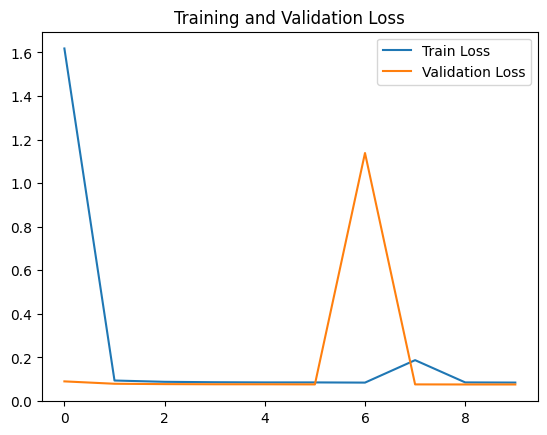

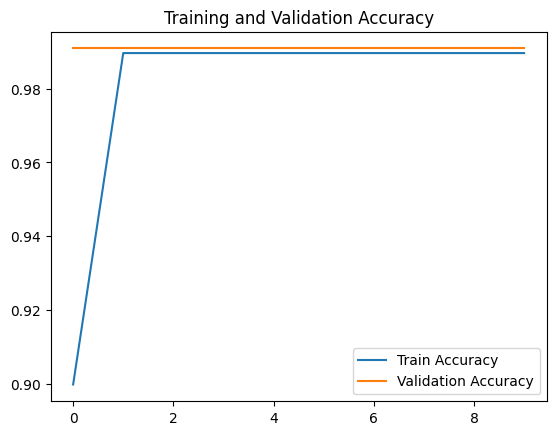

In [102]:
import matplotlib.pyplot as plt
# Assuming history contains training and validation loss/accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']  # Assuming model compiles with 'accuracy' metric
val_acc = history.history['val_accuracy']


# Plot loss curves
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy curves (if applicable)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [103]:
print("Accuracy of LSTM: ",np.mean(train_acc)*100)

Accuracy of LSTM:  98.06566298007965


# Bi-LSTM


In [104]:
from tensorflow.keras.layers import Bidirectional

def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):

  model = Sequential()
  model.add(Embedding(in_vocab, units, mask_zero=True))
  model.add(Masking(mask_value=0.0))
  model.add(Bidirectional(LSTM(units, return_sequences=True)))  # First BiLSTM layer
  model.add(Bidirectional(LSTM(units)))  # Second biLSTM layer (optional)
  model.add(RepeatVector(out_timesteps))
  model.add(Bidirectional(LSTM(units, return_sequences=True)))  # Decoder BiLSTM
  model.add(Dense(out_vocab, activation='softmax'))

  # Compile model with RMSprop optimizer, sparse categorical crossentropy loss, and early stopping
  model.compile(optimizer=RMSprop(learning_rate=0.01), loss='sparse_categorical_crossentropy')
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)

  return model, early_stopping

In [105]:
units = 128

model, early_stopping = define_model(ctg_vocab, bn_vocab, ctg_length, bn_length, units)

model.compile(optimizer=RMSprop(learning_rate=0.01), loss='sparse_categorical_crossentropy')



In [106]:
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [107]:
history=model.fit(trainX,trainY.reshape(trainY.shape[0],trainY.shape[1],1),epochs=10,batch_size=64,validation_split=0.2)

Epoch 1/10
12/12 [==============================] - 27s 706ms/step - loss: 1.2489 - accuracy: 0.8998 - val_loss: 0.0953 - val_accuracy: 0.9909
Epoch 2/10
12/12 [==============================] - 2s 178ms/step - loss: 0.0943 - accuracy: 0.9896 - val_loss: 0.0804 - val_accuracy: 0.9909
Epoch 3/10
12/12 [==============================] - 1s 111ms/step - loss: 0.0873 - accuracy: 0.9896 - val_loss: 0.0831 - val_accuracy: 0.9909
Epoch 4/10
12/12 [==============================] - 1s 109ms/step - loss: 0.0870 - accuracy: 0.9896 - val_loss: 0.0823 - val_accuracy: 0.9909
Epoch 5/10
12/12 [==============================] - 1s 89ms/step - loss: 0.0866 - accuracy: 0.9896 - val_loss: 2.8196 - val_accuracy: 0.9471
Epoch 6/10
12/12 [==============================] - 1s 103ms/step - loss: 0.3842 - accuracy: 0.9859 - val_loss: 0.1054 - val_accuracy: 0.9909
Epoch 7/10
12/12 [==============================] - 1s 89ms/step - loss: 0.1052 - accuracy: 0.9896 - val_loss: 0.0836 - val_accuracy: 0.9909
Epoch 8

In [108]:
preds = model.predict(testX.reshape(testX.shape[0], testX.shape[1]))


7/7 [==============================] - 9s 34ms/step


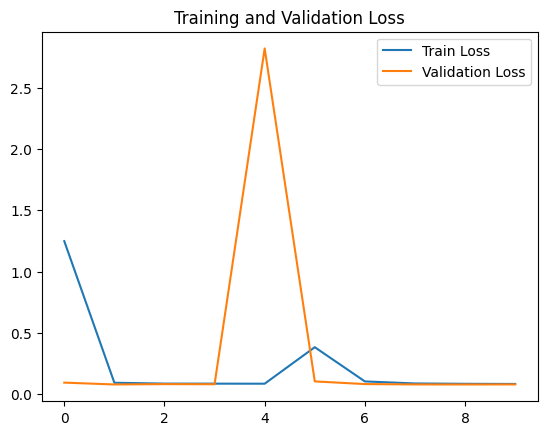

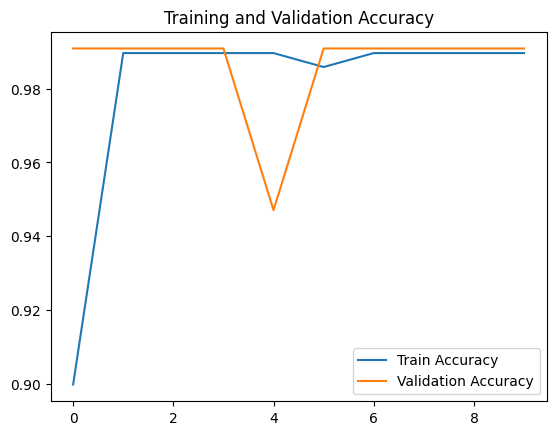

In [109]:
import matplotlib.pyplot as plt
# Assuming history contains training and validation loss/accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']  # Assuming model compiles with 'accuracy' metric
val_acc = history.history['val_accuracy']


# Plot loss curves
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy curves (if applicable)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [110]:
print("Accuracy of BiLSTM: ",np.mean(train_acc)*100)

Accuracy of BiLSTM:  98.02811622619629
